# **Studies for post-peak behavior**

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant

In [2]:
# mp_ms1 = dict(
#     E = 40e+3,
#     nu = 0.18,
#     Ad = 1000.0,
#     eps_0 = 0.00001,
#     K_N = 0.,
#     sigma_N_0 = 1.,
#     gamma_N = 0.,
#     sigma_T_0 = 0.1,
#     K_T = 10.0,
#     gamma_T = 10.,
#     S_T = 0.00000001,
#     c_T = 1.0,
#     r_T = 1.0,
#     m_T = 0.1,
#     p_T = 1.
# )

mp_mdm = dict(
    epsilon_0 = 59.0e-6,
    epsilon_f = 250.0e-6,
    c_T = 0.0,
    E = 28000,
    nu = 0.18
)

## Simple Ligament Discretization 

In [3]:
mp_ms1 = dict(
    E = 28e+3,
    nu = 0.18,
    Ad = 5000.0,
    eps_0 = 0.0001,
    K_N = 0.,
    sigma_N_0 = 20.,
    gamma_N = 0.,
    sigma_T_0 = 5,
    K_T = 10.0,
    gamma_T = 10.,
    S_T = 0.000001,
    c_T = 1.0,
    r_T = 1.0,
    m_T = 0.1,
    p_T = 1.
)

In [ ]:
n_x_e = 5
n_inner_y_e = 2
n_outer_y_e = 2
L_x = 50.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 2 # [mm]
R_out = 50 # [mm]
len_notch = 20
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

E = 34000

m_inelastic = MS13D(**mp_ms1)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [ ]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.0)

In [ ]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


In [ ]:
factor = 1

# Boundary conditions with inner side fixed

slide = 0.01
compression_stress = -0

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice
upper_fixed_1 = confinement_upper_slice

compression_force = compression_stress * 2 * np.pi * R_out * L_x / len(confinement_upper_dofs)
upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                 time_function=tf_precrompression)
                           for dof in confinement_upper_dofs]
upper_compression_force[0].value *= 0.5
upper_compression_force[-1].value *= 0.5

slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                     for dof in slide_upper_dofs]
bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

In [ ]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.02/factor
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

In [ ]:
U_slide_eq = np.linspace(0,slide*factor,int(1/0.02*factor + 1))
U_t = np.average(m.hist.U_t[:, slide_upper_dofs] - m.hist.U_t[:, slide_lower_dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)

In [ ]:
fig, (ax1) = plt.subplots(1)
ax1.plot(U_t, F_t/1000, label='ligament')
# ax1.plot(U_slide_differential_ligament, -F_slide/1000, label='PTST')
ax1.set_ylabel('Force [kN]')
ax1.set_xlabel('Displacement[mm]')
ax1.legend()
# ax2.plot(-U_t/(L_x-n_notch*2*d_x), -F_t/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)))
# # ax2.plot(-U_t/(L_x-n_notch*2*d_x), -F_t/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)))
# # ax2.set_ylabel('Stress [MPa]')
# # ax2.set_xlabel('Strain[-]')
# G = np.trapz(F_t, x=U_t)/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x))*1000
# G2 = np.trapz(F_t/(2 * np.pi * (R_in+dR)), x=U_t/(L_x-n_notch*2*d_x))
# print(G)
# print(G2)
# print(max(-F_t/1000))

In [ ]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Complete PTST

In [4]:
n_x_e = 5
n_inner_y_e = 2
n_outer_y_e = 2
L_x = 50.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 2 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1
# geo_transform
# gmesh
xd_inner = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, 0),
                               coord_max=(L_x, R_in),
                               shape=(n_x_e, n_inner_y_e),
                               fets=FETS2D4Q())
xd_middle = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())
xd_outer = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, R_in+dR),
                               coord_max=(L_x, R_out),
                               shape=(n_x_e, n_outer_y_e),
                               fets=FETS2D4Q())
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m_inelastic_MDM = MATS3DMplDamageEEQ(**mp_mdm)

m_inelastic_MS1 = MS13D(**mp_ms1)

m = TStepBC(
    domains=[(xd_inner, m_inelastic_MDM),
             (xd_outer, m_inelastic_MDM),
             (xd_middle, m_inelastic_MS1),
             ]
)

## Boundary and transition conditions

In [5]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.0)
tf_sliding = TFBilinear(loading_ratio = 0.6, time_ratio=0.2)
#tf_sliding.interact()

### Kinematic links between the domains

In [6]:
link_inner_middle_0 = BCSliceI(var='u', dims=[0],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_inner_middle_1 = BCSliceI(var='u', dims=[1],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

link_middle_outer_0 = BCSliceI(var='u', dims=[0],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_middle_outer_1 = BCSliceI(var='u', dims=[1],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

# link_middle_outer = BCSliceI(var='u', dims=[0, 1],
#                              slice=xd_middle.mesh.I[n_notch:-n_notch, 0], 
#                              # slice=xd_outer.mesh.I[:, 0], 
#                              link_slice=xd_outer.mesh.I[:, -1],
#                              link_coeffs=[1, 1],
#                              link_dims=[0, 1],
#                              value=0,
#                             )

## Sliding dc + Precompression fc

In [8]:
inner_fixed_1 = BCSliceI(slice=xd_inner.mesh.I[:, 0], var='u', dims=[1], value=0)
outer_fixed_0 = BCSliceI(slice=xd_outer.mesh.I[0, :], var='u', dims=[0], value=0)
inner_fixed_out_1 = BCSliceI(slice=xd_inner.mesh.I[:, -1], var='u', dims=[1], value=0)

slide = 0.04
inner_slide_slice = BCSliceI(slice=xd_inner.mesh.I[-1, :],
                                   var='u', dims=[0], value=-0.1)

slide_control_dofs = inner_slide_slice.dofs
inner_slide = [BCDof(var='u', dof=dof, value=-slide, time_function=tf_sliding) 
                     for dof in slide_control_dofs ]


outer_compression_slice = BCSliceI(slice=xd_outer.mesh.I[:, -1],
                                   var='u', dims=[1], value=-0.1)

compression_dofs = outer_compression_slice.dofs
compression_stress = -0
compression_force = compression_stress  * 2* np.pi* R_out * L_x / len(compression_dofs)
outer_compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]

compression_dofs_inner = inner_fixed_out_1.dofs
outer_compression_force_inner_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs_inner ]


# outer_compression_force_first = [BCDof(var='u', dof=dof, value=0.01, time_function=tf_precrompression) 
#                                  for dof in compression_dofs ]
# outer_compression_force_first[0].value *=0.5
# outer_compression_force_first[-1].value *=0.5
outer_compression_force_inner_first[0].value *=0.5
outer_compression_force_inner_first[-1].value *=0.5

bc1 =   [inner_fixed_1,
        outer_fixed_0,
        link_middle_outer_0,
         link_middle_outer_1,
        link_inner_middle_0,
         link_inner_middle_1
        ]  + inner_slide # + outer_compression_force_first

In [9]:
ligament_upper_slide_slice = BCSliceI(slice=xd_middle.mesh.I[:, -1],
                                   var='u', dims=[0], value=-0.1)
ligament_upper_slide_dofs = ligament_upper_slide_slice.dofs

ligament_lower_slide_slice = BCSliceI(slice=xd_middle.mesh.I[:, 0],
                                   var='u', dims=[0], value=-0.1)
ligament_lower_slide_dofs = ligament_lower_slide_slice.dofs

ligament_upper_confinement_slice = BCSliceI(slice=xd_middle.mesh.I[:, -1],
                                   var='u', dims=[1], value=-0.1)
ligament_upper_confinement_dofs = ligament_upper_confinement_slice.dofs

ligament_lower_confinement_slice = BCSliceI(slice=xd_middle.mesh.I[:, 0],
                                   var='u', dims=[1], value=-0.1)
ligament_lower_confinement_dofs = ligament_lower_confinement_slice.dofs

In [10]:
m.bc=bc1
m.hist.vis_record = {
    'strain': Vis3DTensorField(var='eps_ab'),
#    'damage': Vis3DTensorField(var='omega_ab'),
    'strain_p': Vis3DTensorField(var='eps_p_ab'),
    'max_omega': Vis3DStateField(var='max_omega'),
#     'max_omega_T': Vis3DStateField(var='max_omega_T'),
#     'max_omega_N': Vis3DStateField(var='max_omega_N'),
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains

In [11]:
s.reset()
s.run()

t:	 0.00(0), 
	 0.01(1), 
	 0.02(1), 
	 0.03(1), 
	 0.04(1), 
	 0.05(10), 
	 0.06(22), 
	 0.07(20), 
	 0.08(16), 
	 0.09(15), 
	 0.10(22), 
	 0.11(27), 
	 0.12(26), 
	 0.13(51), 
	 0.14(81), 
	 0.15(113), 
	 0.16(92), 
	 0.17(61), 
	 0.18(53), 
	 0.19(41), 
	 0.20(37), 
	 0.21(32), 
	 0.22(33), 
	 0.23(34), 
	 0.24(33), 
	 0.25(32), 
	 0.26(32), 
	 0.27(32), 
	 0.28(34), 
	 0.29(33), 
	 0.30(47), 
	 0.31(44), 
	 0.32(41), 
	 0.33(40), 
	 0.34(38), 
	 0.35(36), 
	 0.36(36), 
	 0.37(34), 
	 0.38(34), 
	 0.39(33), 
	 0.40(49), 
	 0.41(46), 
	 0.42(43), 
	 0.43(42), 
	 0.44(41), 
	 0.45(38), 
	 0.46(36), 
	 0.47(36), 
	 0.48(36), 
	 0.49(42), 
	 0.50(43), 
	 0.51(41), 
	 0.52(42), 
	 0.53(41), 
	 0.54(40), 
	 0.55(38), 
	 0.56(39), 
	 0.57(40), 
	 0.58(39), 
	 0.59(39), 
	 0.60(39), 
	 0.61(81), 
	 0.62(75), 
	 0.63(73), 
	 0.64(68), 
	 0.65(63), 
	 0.66(57), 
	 0.67(53), 
	 0.68(52), 
	 0.69(57), 
	 0.70(59), 
	 0.71(57), 
	 0.72(54), 
	 0.73(59), 
	 0.74(46), 
	 0.75(47), 
	 0.76(50), 
	

## Postprocesing

### Access the last displacement step

In [12]:
F = m.hist.F_t
U = m.hist.U_t

In [13]:
F_slide = np.sum(F[:, slide_control_dofs], axis=-1)
F_slide_ligament_upper = np.sum(F[:, ligament_upper_slide_dofs], axis=-1)
F_slide_ligament_lower = np.sum(F[:, ligament_lower_slide_dofs], axis=-1)
F_confinement_ligament_upper = np.sum(F[:, ligament_upper_confinement_dofs], axis=-1)
F_confinement_ligament_lower = np.sum(F[:, ligament_lower_confinement_dofs], axis=-1)
U_slide = np.average(U[:, slide_control_dofs], axis=-1)
U_slide_ligament_upper = np.average(U[:, ligament_upper_slide_dofs], axis=-1)
U_slide_ligament_lower = np.average(U[:, ligament_lower_slide_dofs], axis=-1)
U_slide_differential_ligament = U_slide_ligament_upper - U_slide_ligament_lower

In [14]:
_, ax = plt.subplots(1,1)
ax.plot(-U_slide, -F_slide/1000)
ax.set_ylabel('Force [kN]')
ax.set_xlabel('Displacement at control[mm]')
# ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Displacement at control[mm]')

In [ ]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'strain'
    strain_viz = Viz3DTensorField(vis3d=m.hist['strain_p'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    strain_viz = Viz3DScalarField(vis3d=m.hist['max_omega'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

### Study about slide profile at ligament

In [61]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    # ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i], label=str(i))
    # ax.plot(U_slide_differential_ligament, U[:, ligament_lower_slide_dofs][:,i], label=str(i))
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i], label='Position' + str(i))
ax.set_ylabel('Displacement at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Study about confinement profile at ligament

In [62]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    # ax.plot(U_slide_differential_ligament[:], F[:, ligament_upper_confinement_dofs][:,i]/1000, label=str(i))
    # ax.plot(U_slide_differential_ligament[:], F[:, ligament_lower_confinement_dofs][:,i]/1000, label=str(i))
    ax.plot(U_slide_differential_ligament, (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/1000, label='Position' + str(i))
ax.set_ylabel('Force at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Study about dilatancy profile at ligament

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
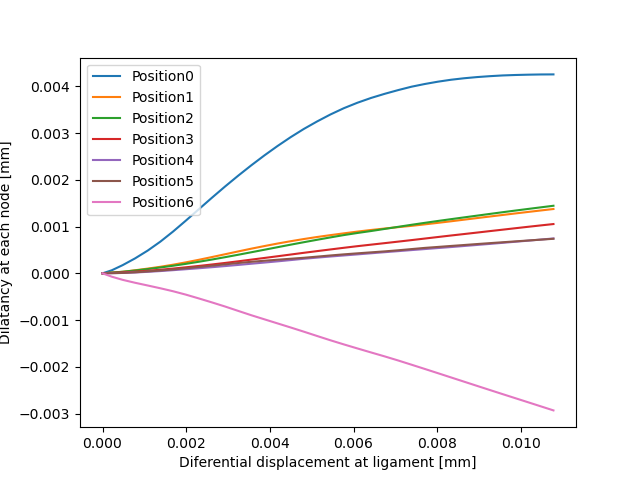

In [119]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    # ax.plot(U_slide_differential_ligament[:], U[:, ligament_upper_confinement_dofs][:,i], label= 'Position' + str(i))
    # ax.plot(U_slide_differential_ligament[:], U[:, ligament_lower_confinement_dofs][:,i], label= 'Position' + str(i))
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i], label = 'Position' + str(i))
ax.set_ylabel('Dilatancy at each node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()
